# Shortest Paths on OpenStreetMap

Ozan Tuncbilek - 08.02.2022

1. Data Preperation 
    * Readings OSM Data 
    * Parse/clean the raw OSM data
    * Apply Bounding Box
2. Shortest Path Algortihm Two-Q 
3. Visualization 


In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import osmnx as ox
import os
import networkx as nx
import matplotlib.pyplot as plt
import scipy

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Data Preperation
    1 Parse data
    2 converting data from graph to GeoDataFrame
    3 Explore, plot

In [2]:
#Parse OSM Munich center data with OSMNX library as graph 
muc_graph = ox.graph.graph_from_xml('../input/munich-osm/munich_center.osm', simplify=True, retain_all=False)

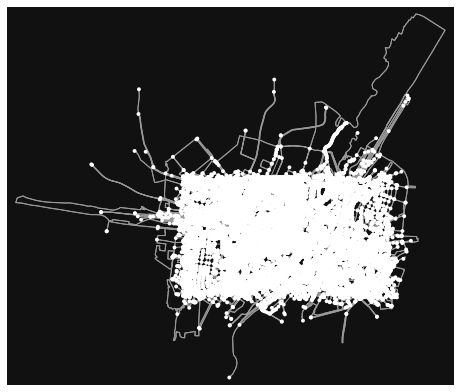

In [3]:
#Plot the streets 
fig, ax = ox.plot_graph(muc_graph) 

In [4]:
#Project the graph: re-project the graph from latitudes and longitudes to an appropriate UTM zone
muc_graph_proj = ox.project_graph(muc_graph)

In [5]:
#Retrieve Edges and Nodes from the graph
edges = ox.graph_to_gdfs(muc_graph, nodes=False, edges=True)

In [6]:
#Check the data with Lat, long format
edges.head()

osmid  oneway lanes  \
u      v          key                                                    
277381 1099934871 0                              4471065    True     2   
       775283935  0                            543004597   False     4   
       295209     0                            292767090   False     4   
277382 8678913443 0                             48919211   False     4   
       775283935  0    [543004595, 543004596, 543004597]   False     4   

                                      name    highway maxspeed   length  \
u      v          key                                                     
277381 1099934871 0    Martin-Greif-Straße  secondary       50   13.595   
       775283935  0     Schwanthalerstraße  secondary       50    7.933   
       295209     0     Schwanthalerstraße  secondary       50   10.991   
277382 8678913443 0     Schwanthalerstraße  secondary       30   46.433   
       775283935  0     Schwanthalerstraße  secondary       50  126.170   

                                                                geometry  \
u      v          key                                                      
277381 1099934871 0    LINESTRING (11.54980 48.13755, 11.54981 48.13767)   
       775283935  0    LINESTRING (11.54980 48.13755, 11.54991 48.13755)   
       295209     0    LINESTRING (11.54980 48.13755, 11.54974 48.137...   
277382 8678913443 0    LINESTRING (11.55161 48.13754, 11.55223 48.13753)   
       775283935  0    LINESTRING (11.55161 48.13754, 11.55119 48.137...   

                      landuse service access  ref bridge area tunnel width  \
u      v          key                                                        
277381 1099934871 0       NaN     NaN    NaN  NaN    NaN  NaN    NaN   NaN   
       775283935  0       NaN     NaN    NaN  NaN    NaN  NaN    NaN   NaN   
       295209     0       NaN     NaN    NaN  NaN    NaN  NaN    NaN   NaN   
277382 8678913443 0       NaN     NaN    NaN  NaN    NaN  NaN    NaN   NaN   
       775283935  0       NaN     NaN    NaN  NaN    NaN  NaN    NaN   NaN   

                      junction est_width  
u      v          key                     
277381 1099934871 0        NaN       NaN  
       775283935  0        NaN       NaN  
       295209     0        NaN       NaN  
277382 8678913443 0        NaN       NaN  
       775283935  0        NaN       NaN

In [7]:
#Retrieve Edges and Nodes from the graph with corrected projection
nodes_proj, edges_proj = ox.graph_to_gdfs(muc_graph_proj, nodes=True, edges=True)

In [8]:
edges_proj.crs

<Projected CRS: +proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:title={'center':'Road Types'}>

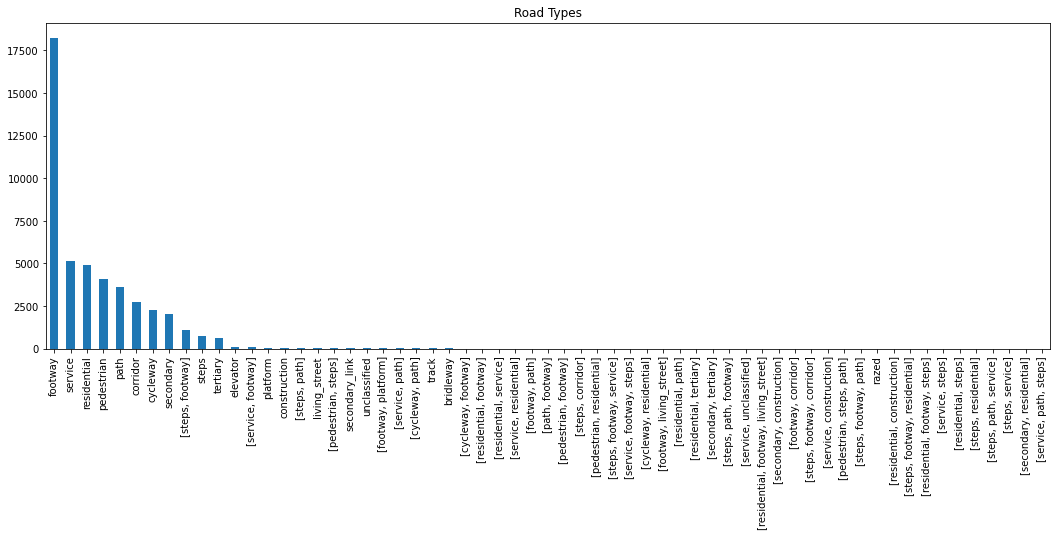

In [9]:
#Check the stats of the data 
edges_proj.highway.value_counts().plot.bar(figsize=(18,6), title = "Road Types")

<AxesSubplot:title={'center':'Road Types'}>

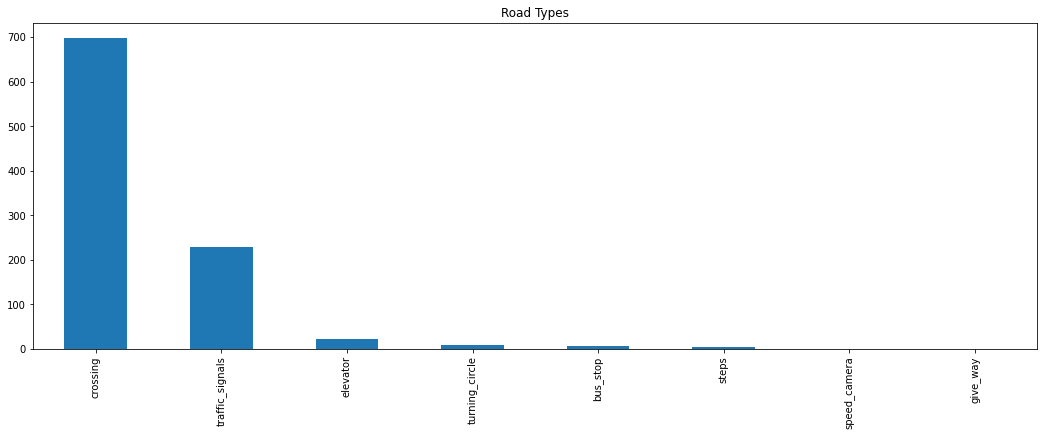

In [10]:
nodes_proj.highway.value_counts().plot.bar(figsize=(18,6), title = "Road Types")

### Shortest Path Algorithm Two-Q 
    1. Get Origin and Target Point
    2. Implement Two-Q

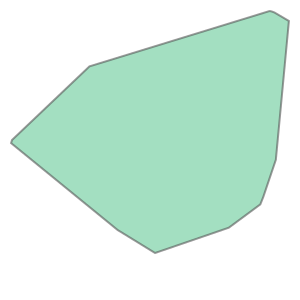

In [11]:
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull
# Show output
convex_hull

In [12]:
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull

# Centroid
centroid = convex_hull.centroid

# Show
print(centroid)

POINT (691008.1945096498 5335856.458416032)


In [13]:
dest =list(muc_graph_proj)[-1]
dest

8796396277

In [14]:
#Find the Origin and Target point

# Get the x coordinates of the nodes
nodes_proj['x'] = nodes_proj["x"].astype(float)

In [15]:
minn = nodes_proj['x'].min()

In [16]:
target = nodes_proj.loc[nodes_proj['x']==minn, 'geometry'].values[0]
print(target)

POINT (686896.0979297942 5336447.337619171)


In [17]:
# Get origin x and y coordinates
orig_xy = (centroid.y, centroid.x)

# Get target x and y coordinates
target_xy = (target.y, target.x)

In [18]:
# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node = ox.get_nearest_node(muc_graph_proj, orig_xy, method='euclidean')
print("Origin node", orig_node)

# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node = ox.get_nearest_node(muc_graph_proj, target_xy, method='euclidean')
print("Target node", target_node)


/opt/conda/lib/python3.7/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


Origin node 2349278103
Target node 297265330


In [19]:
# Retrieve the rows from the nodes GeoDataFrame
o_closest = nodes_proj.loc[orig_node]
t_closest = nodes_proj.loc[target_node]

In [20]:
# Create a GeoDataFrame from the origin and target points
od_nodes = gpd.GeoDataFrame([o_closest, t_closest], geometry='geometry', crs=nodes_proj.crs)
od_nodes.head()

,y,x,lon,lat,highway,ref,geometry
2349278103,5.335847e+06,691012.410044,11.568048,48.147169,NaN,NaN,POINT (691012.410 5335847.157)
297265330,5.336447e+06,686896.097930,11.513026,48.153786,NaN,NaN,POINT (686896.098 5336447.338)


In [21]:
# Calculate the shortest path
route = nx.shortest_path(G=muc_graph_proj, source=orig_node, target=dest, weight='length', method='bellman-ford')

# Show what we have
print(route)

[2349278103, 5223300525, 4551536152, 2349280788, 8748721382, 2349280789, 2349280790, 8748721367, 8748721365, 8748721366, 4475893235, 4475893234, 1776756989, 3953206273, 3580477949, 3580477928, 3228070929, 976966588, 976966517, 307678631, 7962153112, 976966510, 307678632, 19103948, 2489934376, 18668563, 2489934347, 2489934213, 18668562, 1635744315, 19471652, 2038188, 282335659, 1059560784, 282335654, 3936361490, 1059560412, 1059560725, 1059560622, 1059560671, 1121737116, 3689034551, 6149588457, 3689034543, 3689034541, 292929906, 1239166841, 1955015, 340082597, 1955013, 256017127, 1120370515, 1955016, 1955018, 30959172, 8220452977, 8220452984, 8220452982, 8220452983, 20225973, 20225971, 20226760, 3612597608, 282339866, 20225970, 20225977, 8042917597, 8042855115, 8042949312, 1955054, 18933344, 1368309490, 295122, 292766574, 3565730183, 595390728, 1493218246, 254075510, 4748640020, 4748640019, 3680522990, 3565730178, 1689058986, 1689007015, 1689007008, 1689007001, 3566017425, 1688834618, 2

In [22]:
nodes_proj


,y,x,lon,lat,highway,ref,geometry
osmid,,,,,,,
277381,5.334733e+06,689690.637375,11.549800,48.137551,NaN,NaN,POINT (689690.637 5334733.086)
1099934871,5.334747e+06,689691.072927,11.549811,48.137673,crossing,NaN,POINT (689691.073 5334746.674)
775283935,5.334733e+06,689698.591402,11.549906,48.137551,crossing,NaN,POINT (689698.591 5334733.295)
295209,5.334733e+06,689679.616310,11.549651,48.137552,NaN,NaN,POINT (689679.616 5334732.843)
277382,5.334736e+06,689825.106302,11.551607,48.137540,NaN,NaN,POINT (689825.106 5334736.324)
...,...,...,...,...,...,...,...
8791268363,5.333774e+06,692166.025273,11.582606,48.128187,NaN,NaN,POINT (692166.025 5333773.877)
8796396274,5.333299e+06,693980.758359,11.606753,48.123366,NaN,NaN,POINT (693980.758 5333298.704)
8796396275,5.333292e+06,693972.505141,11.606639,48.123305,NaN,NaN,POINT (693972.505 5333291.649)


In [23]:
edges_proj.length[25575939].keys()[0][0]

edges_proj.length[277381][edges_proj.length[277381].keys()[0][0]].values[0]
edges_proj.length[277381].keys().values

{e[0] : edges_proj.length[277381][e[0]].values[0] for e in edges_proj.length[277381].keys().values}



KeyError: 25575939

In [ ]:
from enum import Enum

class State(Enum):
    UNREACHED = 1
    IN_QUEUE =  2
    SCANED = 3

In [ ]:
def init_queues(nodes, source, labels, states):
    low_q = []
    high_q = []

    for i in range(len(nodes)):
        labels[nodes.iloc[i].name] = float("inf")
        states[nodes.iloc[i].name] = State.UNREACHED

    labels[source] = 0
    states[source] = State.IN_QUEUE
    low_q.append(source)

    return low_q, high_q

In [ ]:
def extract(low_q, high_q):
    if high_q:
        return high_q.pop(0)
    else: 
        return low_q.pop(0)

In [ ]:
def scan(low_q, high_q, labels, states, i, edges):
    arcs = {}
    if i in edges.length:
        arcs = {e[0] : edges.length[i][e[0]].values[0] for e in edges.length[i].keys().values}

    for j in arcs:
        if labels[i] + arcs[j] < labels[j]:
            labels[j] = labels[i] + arcs[j]

            if states[j] == State.SCANED:
                high_q.append(j)
            elif states[j] == State.UNREACHED:
                low_q.append(j)
            states[j] = State.IN_QUEUE


    states[i] = State.SCANED

In [ ]:
def two_q(graph, source, target):
    
    nodes_proj, edges_proj = ox.graph_to_gdfs(graph, nodes=True, edges=True)

    labels = {}
    states = {}

    low_q, high_q = init_queues(nodes_proj, source, labels, states)
    
    while(high_q or low_q):
        i = extract(low_q, high_q)
        scan(low_q, high_q, labels, states, i, edges_proj)

    print(labels)

    return labels

In [ ]:
labels = two_q(muc_graph_proj, orig_node,target_node)

In [ ]:
u = pd.DataFrame(list(edges_proj.length.keys()), columns=["u", "v", "key"])
u

In [ ]:
u.loc[u["v"]==1099934871].u.values

In [ ]:
edges_proj

### Visaulization
    1. Get Route nodes from calculated route
    2. Visualize with Keplergl

In [ ]:
# Get the nodes along the shortest path
route_nodes = nodes_proj.loc[route]
route_nodes

In [ ]:
route_edges = edges_proj.loc[route]
route_edges.head(5)

In [ ]:
config = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '8qdqs2m',
     'type': 'geojson',
     'config': {'dataId': 'muc',
      'label': 'muc',
      'color': [77, 193, 156],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'geojson': 'geometry'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'stroked': True,
       'filled': False,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': 'p557il8',
     'type': 'geojson',
     'config': {'dataId': 'edges',
      'label': 'edges',
      'color': [23, 184, 190],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'geojson': 'geometry'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'stroked': False,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': 'qwigsz',
     'type': 'geojson',
     'config': {'dataId': 'network',
      'label': 'network',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'geojson': 'geometry'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'strokeOpacity': 0.8,
       'thickness': 0.1,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'stroked': True,
       'filled': False,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'muc': [{'name': 'osmid',
        'format': None},
       {'name': 'oneway', 'format': None},
       {'name': 'lanes', 'format': None},
       {'name': 'name', 'format': None},
       {'name': 'highway', 'format': None}],
      'edges': [{'name': 'y', 'format': None},
       {'name': 'x', 'format': None},
       {'name': 'highway', 'format': None},
       {'name': 'ref', 'format': None}],
      'network': [{'name': 'osmid', 'format': None},
       {'name': 'oneway', 'format': None},
       {'name': 'lanes', 'format': None},
       {'name': 'name', 'format': None},
       {'name': 'highway', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 48.13095857731462,
   'longitude': 11.586642695981286,
   'pitch': 0,
   'zoom': 12.993509727831723,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [ ]:
from keplergl import KeplerGl

route_muc = KeplerGl(height=700,data={"muc": route_edges, "edges": route_nodes, "network": edges_proj, "nodes":nodes_proj})
route_muc.config = config
route_muc